In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.13.0


In [75]:
train = pd.read_csv(r"D:\emotion_dataset\archive (1)\train.txt",header=None,sep=';',names=['tweets','labels'])
train.head()

,tweets,labels
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Tokenisation

In [76]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [77]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(train['tweets'])

In [92]:
tokenizer.texts_to_sequences([train['tweets'][0]])

[[2, 139, 3, 679]]

## Padding and Truncating Sequences
1. Checking length of the tweets
2. Creating padded sequences

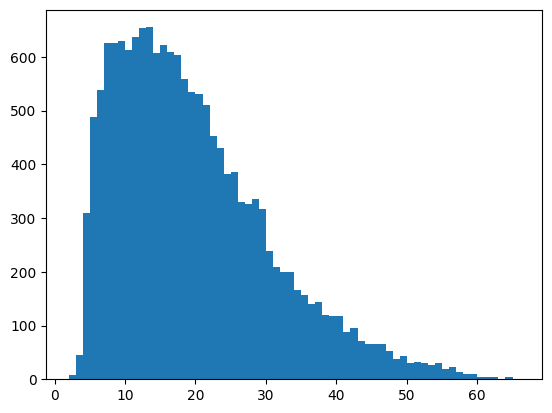

In [93]:
lengths = [len(t.split(' ')) for t in train['tweets']]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [94]:
max_len = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [97]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len)
    return padded

In [98]:
padded_train_seq = get_sequences(tokenizer,train['tweets'])

In [99]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

## Preparing the labels
1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [100]:
classes = set(train['labels'])
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

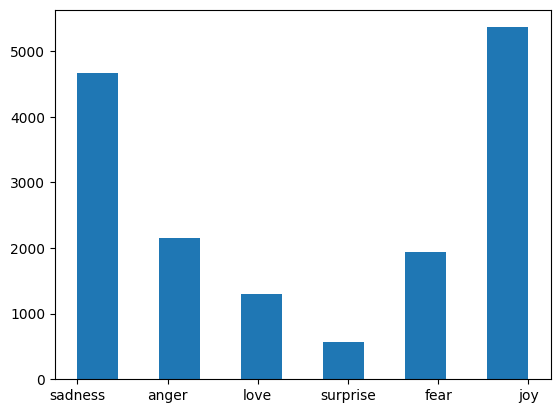

In [101]:
plt.hist(train['labels'], bins=11)
plt.show()

In [102]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())

In [103]:
class_to_index

{'sadness': 0, 'love': 1, 'surprise': 2, 'anger': 3, 'joy': 4, 'fear': 5}

In [104]:
index_to_class

{0: 'sadness', 1: 'love', 2: 'surprise', 3: 'anger', 4: 'joy', 5: 'fear'}

In [105]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [106]:
train_labels = names_to_ids(train['labels'])
print(train_labels[0])

0


## Creating the Model
1. Creating the model
2. Compiling the model

In [109]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(

    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']

)

In [110]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirection  (None, 50, 40)            5920      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training the Model
1. Preparing a validation set
2. Training the model

In [112]:
val = pd.read_csv(r"D:\emotion_dataset\archive (1)\val.txt",header=None,sep=';',names=['tweets','labels'])

In [113]:
val_seq = get_sequences(tokenizer,val['tweets'])
val_labels = names_to_ids(val['labels'])

In [114]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs = 20,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuray', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 21s 31ms/step - loss: 1.2343 - accuracy: 0.5018 - val_loss: 0.7210 - val_accuracy: 0.7255
Epoch 2/20
500/500 [==============================] - 17s 34ms/step - loss: 0.5420 - accuracy: 0.7653 - val_loss: 0.5610 - val_accuracy: 0.7745
Epoch 3/20
500/500 [==============================] - 19s 38ms/step - loss: 0.3884 - accuracy: 0.8295 - val_loss: 0.5495 - val_accuracy: 0.8030
Epoch 4/20
500/500 [==============================] - 19s 39ms/step - loss: 0.2674 - accuracy: 0.9105 - val_loss: 0.4834 - val_accuracy: 0.8550
Epoch 5/20
500/500 [==============================] - 21s 41ms/step - loss: 0.1879 - accuracy: 0.9418 - val_loss: 0.4489 - val_accuracy: 0.8620
Epoch 6/20
500/500 [==============================] - 21s 42ms/step - loss: 0.1512 - accuracy: 0.9542 - val_loss: 0.4507 - val_accuracy: 0.8705
Epoch 7/20
500/500 [==============================] - 21s 41ms/step - loss: 0.1162 - accuracy: 0.9641 - val_loss: 0.4602 - val_accuracy:

## Evaluating the Model
1. Visualizing training history
2. Prepraing a test set
3. A look at individual predictions on the test set
4. A look at all the predictions on the test set

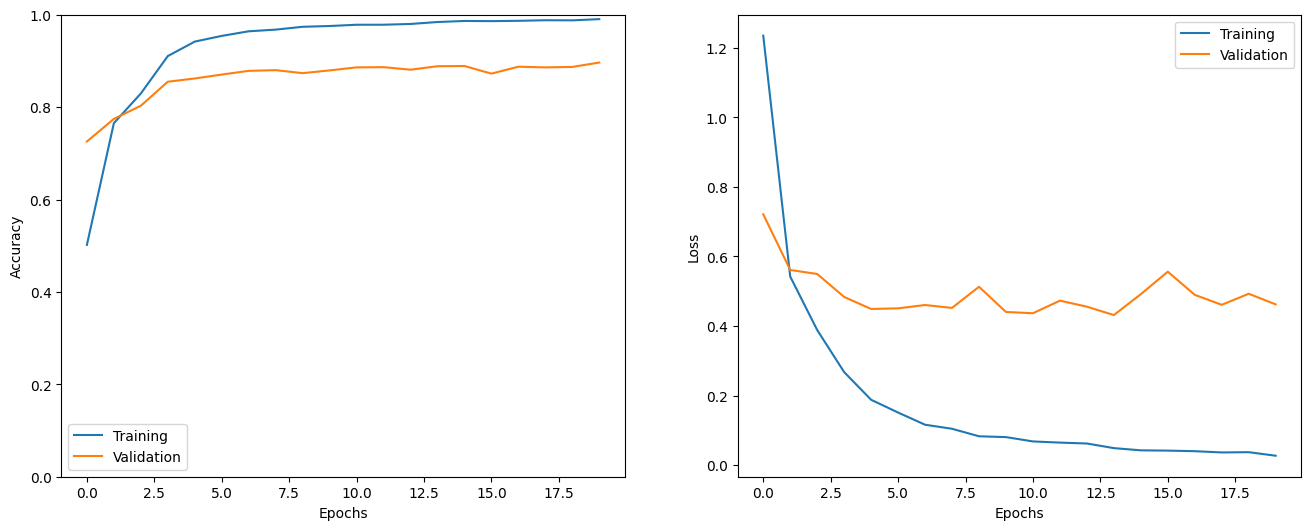

In [115]:
show_history(h)

In [116]:
test = pd.read_csv(r"D:\emotion_dataset\archive (1)\test.txt",header=None,sep=';',names=['tweets','labels'])

In [117]:
test_seq = get_sequences(tokenizer,test['tweets'])
test_labels = names_to_ids(test['labels'])

In [118]:
_ = model.evaluate(test_seq,test_labels)

63/63 [==============================] - 1s 10ms/step - loss: 0.4847 - accuracy: 0.8885


In [128]:
i = random.randint(0, len(test_labels)-1)

print('Sentence:',test['tweets'][i])
print('Emotion:', test['labels'][i])

p = model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i feel fine now even though ive just burned the dinner oops
Emotion: joy
1/1 [==============================] - 0s 25ms/step
Predicted Emotion: joy
